<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/assignment2/assignment_2_lucab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

## Group

* Luca Babboni - luca.babboni2@studio.unibo.it
* Matteo Fasulo - matteo.fasulo@studio.unibo.it
* Maksim Omelchenko - maksim.omelchenko@studio.unibo.it
* Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.

## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist

## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Libraries

In [1]:
%%capture

%pip install -U bitsandbytes

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
import pandas as pd
from pathlib import Path
import requests
import os
import random
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `Deleteme` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Deleteme`


# Download the data

We download the data from the repository of the course.

In [3]:
def download_corpus(url: str, filename: str) -> None:
    """
    Downloads a text corpus from a given URL and saves it to a specified filename within the data folder if not exist

    Args:
        url (str): The URL from which to download the corpus.
        filename (str): The name of the file to save the downloaded corpus.

    Raises:
        requests.exceptions.HTTPError: If the HTTP request returned an unsuccessful status code.

    Side Effects:
        Creates the data folder if it does not exist.
        Writes the downloaded corpus to the specified file.
    """
    data_folder = Path("./data")
    if not data_folder.exists():
      data_folder.mkdir(parents=True)
      print(f"Created folder {data_folder}.")

    if not (data_folder / filename).exists():
      response = requests.get(url)
      response.raise_for_status()
      with open(data_folder / filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
      print(f"Created file {data_folder / filename}.")
    else:
      print(f"File {data_folder / filename} already exists.")

In [4]:
path_test = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/a2_test.csv'
path_demonstrations = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/demonstrations.csv'

In [5]:
download_corpus(path_test, 'a2_test.csv')
download_corpus(path_demonstrations, 'demonstrations.csv')

Created folder data.
Created file data/a2_test.csv.
Created file data/demonstrations.csv.


# Encode a2_test.csv into a pandas.DataFrame object.

In [6]:
df = pd.read_csv('./data/a2_test.csv', encoding='utf-8')
df.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


# [Task 1 - 0.5 points] Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware

## Which LLMs?

The pool of LLMs is ever increasing and it's impossible to keep track of all new entries.

We focus on popular open-source models.

- [Mistral v2](mistralai/Mistral-7B-Instruct-v0.2)
- [Mistral v3](mistralai/Mistral-7B-Instruct-v0.3)
- [Llama v3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)
- [Phi3-mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct)

Other open-source models are more than welcome!

### Instructions

In order to get Task 1 points, we require you to:

* Pick 2 model cards from the provided list.
* For each model:
  - Define a separate section of your notebook for the model.
  - Setup a quantization configuration for the model.
  - Load the model via HuggingFace APIs.


### Notes

1. There's a popular library integrated with Huggingface's ``transformers`` to perform quantization.

2. Define two separate sections of your notebook to show that you have implemented the prompting pipeline for each selected model card.

In [7]:
def load_model(model_card):
  quantization_config = BitsAndBytesConfig(load_in_8bit=True)
  tokenizer = AutoTokenizer.from_pretrained(model_card)
  model_8bit = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
  model_8bit.eval()
  return model_8bit, tokenizer

# Mistral v3 instruct in 8bit

In [8]:
model_card = 'mistralai/Mistral-7B-Instruct-v0.3'
model_8bit, tokenizer = load_model(model_card)

device = model_8bit.device
print(f'Model loaded on {device}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model loaded on cuda:0


# [Task 2 - 1.0 points] Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


## Prompt Template

Use the following prompt template to process input texts.

In [9]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

### Instructions

In order to get Task 2 points, we require you to:

* Write a ``prepare_prompts`` function as the one reported below.

In [10]:
def prepare_prompts(texts, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    # add text
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True,
                                                 add_generation_prompt=True,
                                                 return_dict=True,
                                                 return_tensors="pt").to(device))

  return prompts

In [11]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)

In [12]:
print(tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True))

You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        


### Notes

1. You are free to modify the prompt format (**not its content**) as you like depending on your code implementation.

2. Note that the provided prompt has placeholders. You need to format the string to replace placeholders. Huggingface might have dedicated APIs for this.

# [Task 3 - 1.0 points] Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [13]:
def generate_responses(model, prompt_examples):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
  """
  answers = []
  for prompt in tqdm(prompt_examples):
    response = model.generate(**prompt, max_new_tokens=1000, pad_token_id=tokenizer.eos_token_id)
    answers.append(response)
  return answers

In [14]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """
  response = tokenizer.decode(response[0])
  if 'YES' in response.split('ANSWER')[-1]:
    return 1
  else:
    return 0

In [15]:
answers = generate_responses(model_8bit, prompts)

100%|██████████| 300/300 [04:27<00:00,  1.12it/s]


In [30]:
raw_answers = [tokenizer.decode(item[0]) for item in answers]

In [18]:
batch_predictions = [process_response(item) for item in answers]

In [20]:
Mistral_base_result = pd.DataFrame({
    'text': df['text'],
    'answer': batch_predictions,
    'label': df['label_sexist']
})

In [35]:
for i in range(5):
    print(f"Row {i}:")
    print(f"Text: {Mistral_base_result['text'].iloc[i]}")
    print(f"Answer: {Mistral_base_result['answer'].iloc[i]}")
    print(f"Label: {Mistral_base_result['label'].iloc[i]}")
    print("-" * 20)

Row 0:
Text: The boys must be gaming because there goes the wifi.
Answer: 1
Label: not sexist
--------------------
Row 1:
Text: Look at those eyes. Either someone unexpectedly just fisted her up the dumper, or that bitch is certifiably a nutburger.
Answer: 1
Label: sexist
--------------------
Row 2:
Text: Old man mogs everyone in this sub
Answer: 0
Label: not sexist
--------------------
Row 3:
Text: Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior.
Answer: 1
Label: not sexist
--------------------
Row 4:
Text: So you run back to daddy whenever you need help. I thought men were sooo bad? Lol. Like I said at the end you need the help of men and can't do shit on your own. Your dad must be a major cuck to raise such a stupid daughter, what went wrong
Answer: 1
Label: sexist
--------------------


In [47]:
# prompt: conta quanti elementi nella lista batch prediction sono 0

zeros = batch_predictions.count(0)
print(f"Number of zeros in batch predictions: {zeros}")

Number of zeros in batch predictions: 38


In [48]:
zeros = batch_predictions.count(1)
print(f"Number of ones in batch predictions: {zeros}")

Number of ones in batch predictions: 262


## Notes

1. According to our tests, it should take you ~10 mins to perform full inference on 300 samples.

# [Task 4 - 0.5 points] Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [36]:
def compute_metrics(responses, y_true):
  """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """
  y_pred = [process_response(response) for response in responses]
  accuracy = (np.array(y_pred) == np.array(y_true)).mean()
  fail_ratio = (np.array(y_pred) != np.array(y_true)).mean()
  return {'accuracy': accuracy, 'fail_ratio': fail_ratio}

In [38]:
x_true = df['label_sexist'] == 'sexist'
mistal_base_metrics = compute_metrics(answers, x_true)

In [39]:
mistal_base_metrics

{'accuracy': 0.6133333333333333, 'fail_ratio': 0.38666666666666666}

In [40]:
def analyze_errors(x_true, responses):
  responses = [process_response(response) for response in answers]

  matrix = confusion_matrix(x_true, responses)

  print(f'Correctly classified not sexist samples: {matrix[0][0]}')
  print(f'Correctly classified sexist samples: {matrix[1][1]}')
  print(f'Incorrectly classified not sexist samples: {matrix[0][1]}')
  print(f'Incorrectly classified sexist samples: {matrix[1][0]}')

  print(f'Accuracy: {compute_metrics(answers, x_true)["accuracy"]}')
  # precision and recall
  print(f'Precision: {matrix[1][1] / (matrix[1][1] + matrix[0][1])}')
  print(f'Recall: {matrix[1][1] / (matrix[1][1] + matrix[1][0])}')

In [41]:
analyze_errors(x_true, answers)

Correctly classified not sexist samples: 36
Correctly classified sexist samples: 148
Incorrectly classified not sexist samples: 114
Incorrectly classified sexist samples: 2
Accuracy: 0.6133333333333333
Precision: 0.5648854961832062
Recall: 0.9866666666666667


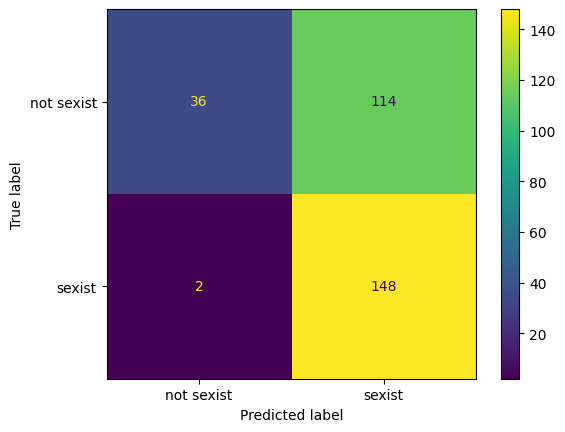

In [44]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

responses = [process_response(response) for response in answers]

confusion_matrix = metrics.confusion_matrix(x_true, responses)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not sexist", "sexist"])

cm_display.plot()
plt.show()

### Lets see some examples of misclassified tweets

In [49]:
def show_random_misclassified(x_true, answers):
  responses = [process_response(response) for response in answers]
  rand_int = random.randint(0, len(answers))

  for ind in range(len(answers)):
    ind += rand_int
    ind %= len(answers)
    if x_true[ind] != responses[ind]:
      print(df['text'][ind])
      print(f'True label: {x_true[ind]}')
      print(f'Predicted label: {responses[ind]}')
      break

In [53]:
def show_random_misclassified(x_true, answers):
  responses = [process_response(response) for response in answers]
  rand_int = random.randint(0, len(answers))

  while x_true[rand_int] == responses[rand_int]:
    rand_int = random.randint(0, len(answers))

  print(df['text'][rand_int])
  print(f'True label: {x_true[rand_int]}')
  print(f'Predicted label: {responses[rand_int]}')

In [54]:
show_random_misclassified(x_true, answers)

Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior.
True label: False
Predicted label: 1


# [Task 5 - 1.0 points] Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [55]:
prompt_few_shot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

In [ ]:
# prompt = [
#     {
#         'role': 'system',
#         'content': 'You are an annotator for sexism detection.'
#     },
#     {
#         'role': 'user',
#         'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

#         EXAMPLES:
#         TEXT: **example 1**
#         ANSWER: YES
#         TEXT: **example 2**
#         ANSWER: NO

#         TEXT:
#         {text}

#         ANSWER:
#         """
#     }
# ]

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [58]:
demonstrations = pd.read_csv('./data/demonstrations.csv')
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


In [59]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
  """
    Inputs:
      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      a list of textual demonstrations to inject into the prompt template.
  """
  yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class)
  no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class)

  few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))

  return few_shot_demonstrations

In [60]:
build_few_shot_demonstrations(demonstrations, num_per_class=2)

['In this climate of thirsty men these women are still adopting a scarcity mentality. Lol just how unattractive are average men? They must be ugly women who only attract ugly men.',
 'Yeah this happens every time. She NEVER gives anyone else that stare except me. Idk what to make of it. Separate issue, but I’m still into her, but I keep bitching out from talking to her',
 'Looks just like the chick who falsely accused me of rape after her BF(that I didn’t know existed) found out I’d been fucking her.',
 'They’ll protect her at all costs. Not because she’s a zipperhead per se, but because she’s, well, not white.']

In [61]:
def prepare_prompts_few_shot(texts, demonstrations, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    demonstration = ''
    for i, d in enumerate(demonstrations):
      if i < len(demonstrations) // 2:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: YES\n'
      else:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: NO\n'

    # remove extra \t
    demonstration = demonstration[1:]
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{examples}', demonstration)

    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)
    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True, add_generation_prompt=True,
              return_dict=True,
              return_tensors="pt").to(device))

  return prompts

## 4-shot

In [62]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Lol the only reason u dumbass muslims are so horny is cuz all your women look like dumptrucks without their burkas which is why they need to marry 50 at a time
	ANSWER: YES
	TEXT: Absolutely agree. Personal responsibility is desperately lacking in the female species. It's kinda in trouble with males, too, but that sorts itself out in the workforce pretty quickly. &#x200B;
	ANSWER: YES
	TEXT: Greece, African and moslems first stop to the UK.
	ANSWER: NO
	TEXT: Huge cope. 0.1% of your local girls date outside of their race and you blame your inceldom on it, what a joke lmao.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [63]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [07:12<00:00,  1.44s/it]


In [64]:
compute_metrics(answers, x_true)

{'accuracy': 0.63, 'fail_ratio': 0.37}

In [66]:
analyze_errors(x_true, answers)

TypeError: 'numpy.ndarray' object is not callable

In [67]:
show_random_misclassified(x_true, answers)

"Where on Earth do you get all your ideas from for your sick jokes?" asked my wife. Then she fell out of her wheelchair.
True label: False
Predicted label: 1


In [68]:
batch_predictions = [process_response(item) for item in answers]
Mistral_4_shot_result = pd.DataFrame({
    'text': df['text'],
    'answer': batch_predictions,
    'label': df['label_sexist']
})

## 8-shot

In [69]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)
answers = generate_responses(model_8bit, prompts_few_shot)
compute_metrics(answers, x_true)

100%|██████████| 300/300 [04:14<00:00,  1.18it/s]


{'accuracy': 0.6133333333333333, 'fail_ratio': 0.38666666666666666}

In [71]:
batch_predictions = [process_response(item) for item in answers]
Mistral_8_shot_result = pd.DataFrame({
    'text': df['text'],
    'answer': batch_predictions,
    'label': df['label_sexist']
})

# Llama 3 8B

In [ ]:
model_card = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16) # this avoids the warning on dtype
tokenizer = AutoTokenizer.from_pretrained(model_card)
model_8bit = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
model_8bit.eval()
device = model_8bit.device
print(f'Model loaded on {device}')

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Zero-shot

In [ ]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)
answers = generate_responses(model_8bit, prompts)

x_true = df['label_sexist'] == 'sexist'
compute_metrics(answers, x_true)

100%|██████████| 300/300 [06:06<00:00,  1.22s/it]


{'accuracy': 0.6766666666666666, 'fail_ratio': 0.3233333333333333}

## 4-shot

In [ ]:
# TODO: for fair comparison, make sure that examples are the same
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)
answers = generate_responses(model_8bit, prompts_few_shot)
compute_metrics(answers, x_true)

100%|██████████| 300/300 [10:55<00:00,  2.19s/it]


{'accuracy': 0.64, 'fail_ratio': 0.36}

## 8-shot

In [ ]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)
answers = generate_responses(model_8bit, prompts_few_shot)
compute_metrics(answers, x_true)

100%|██████████| 300/300 [06:05<00:00,  1.22s/it]


{'accuracy': 0.6833333333333333, 'fail_ratio': 0.31666666666666665}

## Notes

1. You are free to pick any value for ``num_per_class``.

2. According to our tests, few-shot prompting increases inference time by some minutes (we experimented with ``num_per_class`` $\in [2, 4]$).

# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

In [ ]:
responses = process_response(answers)

TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End